## Connecting nodes

In this notebook the images generated in the last notebook are connected using prepared constraint data.

In [1]:
from os import path

import cv2
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

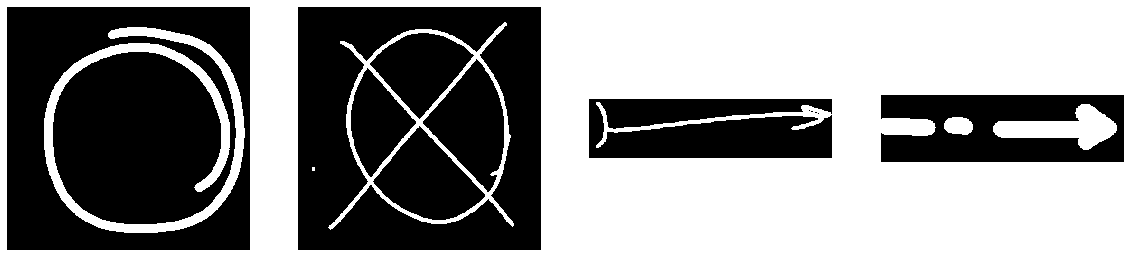

In [2]:
raw = path.join('data', 'sep_raw_02')
interim = path.join('data', 'sep_interim_02')
os.makedirs(interim, exist_ok=True)

node_example  = path.join('data', 'sep_raw_01', 'o', '0.png')
base_example  = path.join('data', 'sep_raw_01', 'x', '0.png')
rot_example   = path.join(raw, 'r', '350-449', '0.png')
trans_example = path.join(raw, 't', '350-449', '0.png')

node_img = cv2.imread(node_example, cv2.IMREAD_GRAYSCALE)
base_img = cv2.imread(base_example, cv2.IMREAD_GRAYSCALE)
rot_img = cv2.imread(rot_example, cv2.IMREAD_GRAYSCALE)
trans_img = cv2.imread(trans_example, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(20,20))

for idx, example in enumerate([node_img, base_img, rot_img, trans_img]):
    plt.subplot(1, 4, idx + 1)
    plt.set_cmap('gray')
    plt.axis('off')
    plt.imshow(example)

plt.show()

### Load prepared images

The `config.json` of the last notebook has to be loaded.
It contains information about where the nodes were placed in the images.

Below are some examples of said images and the respective `head` of the `config.json`.

Information about placed nodes in the first image are printed below the images.

In [3]:
interim_prev = path.join('data', 'sep_interim_01')

df = pd.read_json(path.join(interim_prev, 'config.json'))
df.head()

,image_path,nodes
0,data/sep_interim_01/0.png,"[{'node_path': 'data/sep_raw_01/o/757.png', 'l..."
1,data/sep_interim_01/1.png,"[{'node_path': 'data/sep_raw_01/x/1094.png', '..."
2,data/sep_interim_01/2.png,"[{'node_path': 'data/sep_raw_01/o/1199.png', '..."
3,data/sep_interim_01/3.png,"[{'node_path': 'data/sep_raw_01/x/1164.png', '..."
4,data/sep_interim_01/4.png,"[{'node_path': 'data/sep_raw_01/o/501.png', 'l..."


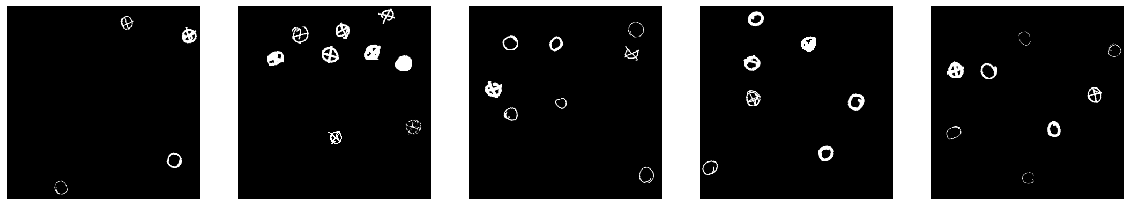

,node_path,label,x,y,b,h
0,data/sep_raw_01/o/757.png,o,311,289,32,32
1,data/sep_raw_01/x/617.png,x,220,32,32,32
2,data/sep_raw_01/o/247.png,o,101,339,32,32
3,data/sep_raw_01/x/880.png,x,340,56,32,32


In [4]:
plt.figure(figsize=(20,20))

for idx, series in df.head().iterrows():
    image = cv2.imread(series.image_path, cv2.IMREAD_GRAYSCALE)
    plt.subplot(1, 5, idx + 1)
    plt.set_cmap('gray')
    plt.axis('off')
    plt.imshow(image)

plt.show()

pd.DataFrame(df.nodes[0])

These images are now connected using the provided constraint data.
The process is similarly "random" by selecting the nodes in the input random and then placing the constraints to create a convincing emulation of real mechanisms (conceptually).

The resulting images do not resemble mechanisms per se, but to detect constraints it is actually not key to create valid data in that regard.

The constraints are scaled and moved rotational/translational to fit between nodes.

The created images have the following attributes:
- Generated images have a target size of 360x360.
- The number of constraints follows a pseudo heuristic, based on the number of connected nodes.
- Constraint-types are selected in a 50/50 fashion.
- Constraints can not connect two nodes more than once.
- The length of the source constraint is always from `350-449`, because the others look strange.
- Coordinates are centered in the middle of the constraint (not the top left).
- Angle and length of the resulting constraint are saved.

Saved metadata is then saved into a `config.json` again.

In [5]:
def pseudo_heuristic(num):
    a = sum(range(num))
    b = a / (num - 1) * 2
    a = np.repeat(True, a - b)
    b = np.repeat(False, b)
    a = np.concatenate((a,b))
    # a = [True, False, False, False, False, False, False]
    return np.random.choice(a)

def place_constraint(c_img, x, y, l, w, background_shape):
    shape = np.multiply(c_img.shape, l / c_img.shape[1])
    shape = tuple(map(int, np.divide(shape, 2)))
    shape = tuple(np.multiply(shape, 2))
    c_img = cv2.resize(c_img, shape[::-1])

    bgs = background_shape
    background = np.zeros(bgs, np.uint8)

    background[int((bgs[0]-shape[0])/2):int((bgs[0]+shape[0])/2),
               int((bgs[1]-shape[1])/2):int((bgs[1]+shape[1])/2)] = c_img

    M = cv2.getRotationMatrix2D((int(bgs[0] / 2), int(bgs[1] / 2)), -w, 1)
    c_img = cv2.warpAffine(background, M, bgs)

    c_img = np.roll(c_img, int(x - bgs[0] / 2))
    c_img = np.roll(c_img, int(y - bgs[1] / 2), 0)

    return c_img

df['constraints'] = None
for image_idx, image_data in tqdm(df.iterrows(), total=len(df)):
    image = cv2.imread(image_data['image_path'], cv2.IMREAD_GRAYSCALE)
    df.constraints[image_idx] = []

    for i in range(len(image_data['nodes'])):
        for j in range(i+1, len(image_data['nodes'])):
            # Pseudo heuristic based on number of nodes:
            if pseudo_heuristic(len(image_data['nodes'])):
                continue

            n1, n2 = image_data['nodes'][i], image_data['nodes'][j]

            dx = n2['x'] - n1['x']
            dy = n2['y'] - n1['y']
            w  = np.arctan2(dy,dx) * 180 / np.pi
            l  = np.hypot(dx, dy) - 50
            if l < 50 or l > 350:
                continue

            x  = int(np.mean((n1['x'], n2['x'])))
            y  = int(np.mean((n1['y'], n2['y'])))

            label = np.random.choice(['r', 't'])

            # tmp = 2 if l >= 350 else 1 if l >= 250 else 0
            tmp = 2
            src_dir = path.join(raw, label)
            src_dir = path.join(src_dir, np.sort(os.listdir(src_dir))[tmp])

            constraint_path = path.join(src_dir, np.random.choice(os.listdir(src_dir)))
            c_img = cv2.imread(constraint_path, cv2.IMREAD_GRAYSCALE)

            image += place_constraint(c_img, x, y, l, w, image.shape)

            w += 360
            w %= 360

            df.constraints[image_idx].append({
                'constraint_path': constraint_path,
                'label': label,
                'idx_n1': i,
                'idx_n2': j,
                'x': x,
                'y': y,
                'w': int(w),
                'l': int(l)
            })

    image_data.image_path = path.join(
        interim, path.basename(image_data.image_path))
    cv2.imwrite(image_data.image_path, image)

df.to_json(path.join(interim, 'config.json'))

100%|██████████| 100000/100000 [32:58<00:00, 50.55it/s]


Examples for generated images:

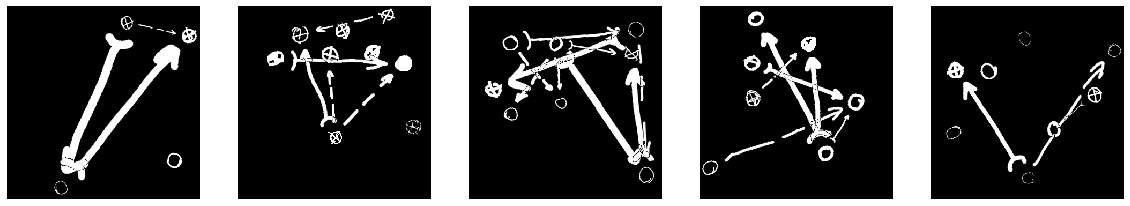

,constraint_path,label,idx_n1,idx_n2,x,y,w,l
0,data\sep_raw_02\r\350-449\391.png,r,1,2,160,185,111,279
1,data\sep_raw_02\t\350-449\139.png,t,1,3,280,44,11,72
2,data\sep_raw_02\r\350-449\20.png,r,2,3,220,197,310,320


In [6]:
plt.figure(figsize=(20,20))

for idx, series in df.head().iterrows():
    image = cv2.imread(series.image_path, cv2.IMREAD_GRAYSCALE)
    plt.subplot(1, 5, idx + 1)
    plt.set_cmap('gray')
    plt.axis('off')
    plt.imshow(image)

plt.show()

pd.DataFrame(df.constraints[0])

In a next step these connections are cropped to get single constraints between two nodes.
These crops can then be used for training of a model.
The respective notebook is `2.2.3-extracting_crops.ipynb`.